# Phase I: Supervised Approach

### Import Required Modules

In [1]:
import os               
import glob             
import random                         
import nibabel as nib                    

import numpy as np
import matplotlib.pyplot as plt              
from sklearn.preprocessing import MinMaxScaler 

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

### Unzip Data Archive
This cell unpacks the archive.zip file in the data directory. If this file has already been unpacked, leave this cell commented out, as it takes several minutes to run.

In [2]:
# import shutil
# shutil.unpack_archive('data/archive.zip', 'data/archive')

### Load, Scale, and Display the First Training Images
As a test, and to get familiar with how the data will be processed, here we load and display slices from the first T1-weighted and T2-weighted images in the training dataset. We also normalize the pixel values to reduce the variance between features.

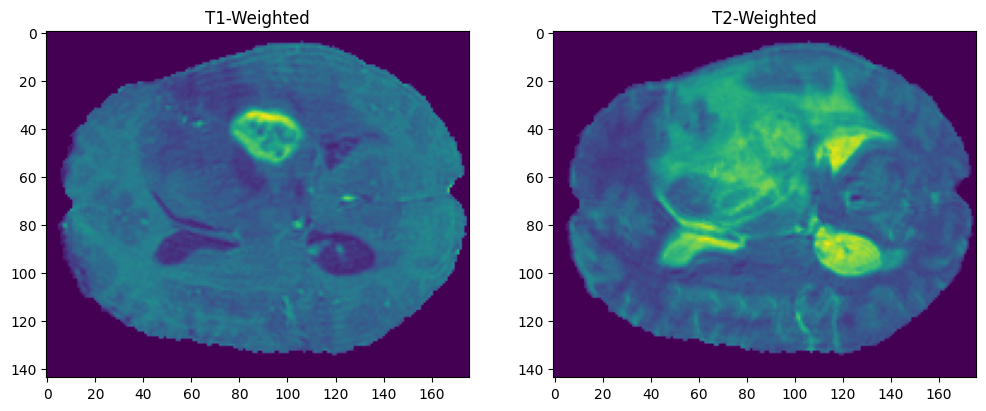

In [3]:
# define the path to the training dataset
trainPath = 'data/archive/MICCAI_BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'

# using nibabel, try to load the first t1-weighted and t2-weighted images
testPathT1 = trainPath + 'BraTS20_Training_001/BraTS20_Training_001_t1ce.nii'
testPathT2 = trainPath + 'BraTS20_Training_001/BraTS20_Training_001_t2.nii'

testImageT1 = nib.load(testPathT1).get_fdata()
testImageT2 = nib.load(testPathT2).get_fdata()

# the raw pixel values range from roughly 0 to 2000; we'll want to rescale them to be 0 to 1
scaler = MinMaxScaler(feature_range=(0, 1))
testImageT1 = scaler.fit_transform(testImageT1.reshape(-1, testImageT1.shape[-1])).reshape(testImageT1.shape)
testImageT2 = scaler.fit_transform(testImageT2.reshape(-1, testImageT2.shape[-1])).reshape(testImageT2.shape)

# crop the images from 240x240x150 to 144x176x64 to reduce useless features (black space)
testImageT1 = testImageT1[48:192,38:214,45:109]
testImageT2 = testImageT2[48:192,38:214,45:109]

# plot middle slice of the two images
n = (0+testImageT1.shape[2])//2
plt.figure(figsize=(12,8))

plt.subplot(121)
plt.imshow(testImageT1[:,:,n])
plt.title('T1-Weighted')

plt.subplot(122)
plt.imshow(testImageT2[:,:,n])
plt.title('T2-Weighted')
plt.show()


### Load All Images

Now that we know how to load in and preprocess an image, let's load in all of the images from the training and validation datasets, preprocess them, and save them as numpy files in the appropriate directories.

<b>Note:</b> once this function is run for training and validation, the entire archive is saved as numpy files, so it does not need to be run again.

In [4]:
def NiiToNpy(dataset):
    # the following two paths are where the .npy files will be stored
    paths = [f'data/archive/MICCAI_BraTS2020_{dataset}Data/numpy/t1',
            f'data/archive/MICCAI_BraTS2020_{dataset}Data/numpy/t2']
    
    # the archive file doesn't initially contain numpy directories, so create them
    for path in paths:
        if not os.path.exists(path):
            os.makedirs(path)
    
    # get the names of every t1 and t2 image in the dataset
    t1Paths = sorted(glob.glob(f'data/archive/MICCAI_BraTS2020_{dataset}Data/MICCAI_BraTS2020_{dataset}Data/BraTS20_{dataset}_*/BraTS20_{dataset}_*_t1ce.nii'))
    t2Paths = sorted(glob.glob(f'data/archive/MICCAI_BraTS2020_{dataset}Data/MICCAI_BraTS2020_{dataset}Data/BraTS20_{dataset}_*/BraTS20_{dataset}_*_t2.nii'))

    # there should be 369 of each contrast in training, 125 in validation
    print(f'Number of T1 {dataset} images:', len(t1Paths), f'\tNumber of T2 {dataset} images:', len(t2Paths))

    # load in all of the training images and preform the same preprocessing from the one-image test
    print(f'\nLoading and preprocessing {dataset} images. This may take a several minutes...')
    for i in range(len(t1Paths)):
        # load ith T1 and T2 .nii images
        t1Image = nib.load(t1Paths[i]).get_fdata()
        t2Image = nib.load(t2Paths[i]).get_fdata()

        # the raw pixel values range from roughly 0 to 2000; we'll want to rescale them to be 0 to 1
        t1Image = scaler.fit_transform(t1Image.reshape(-1, t1Image.shape[-1])).reshape(t1Image.shape)
        t2Image = scaler.fit_transform(t2Image.reshape(-1, t2Image.shape[-1])).reshape(t2Image.shape)

        # crop the images from 240x240x150 to 144x176x64 to reduce useless features (black space)
        t1Image = t1Image[48:192,38:214,45:109] 
        t2Image = t2Image[48:192,38:214,45:109] 

        # save the images as numpy files
        np.save(f'data/archive/MICCAI_BraTS2020_{dataset}Data/numpy/t1/t1_{i+1:03d}.npy', t1Image)
        np.save(f'data/archive/MICCAI_BraTS2020_{dataset}Data/numpy/t2/t2_{i+1:03d}.npy', t2Image)

    print(f'Finished loading and preprocessing {dataset} images.\n')
    return

In [5]:
# NiiToNpy('Training')
# NiiToNpy('Validation')

### Define Custom DataLoader
Here, we define a function used for loading image data from .npy files in batches. This will allow us to work with small subsets of our data at a time, without loading the full dataset. To use this data loader:
1. Create an "instance" of the function.
2. Invoke __next__() on the instance.

For example, the following code could be used to load four images from the directories t1Dir and t2Dir:
```
testLoader = dataLoader(t1Dir, t2Dir, 4)
(t1Images, t2Images) = testLoader.__next__()
```

In [6]:
# loads a single batch of images
def loadBatch(t1SubPaths, t2SubPaths):
    t1Images = []
    t2Images = []

    # for each t1 and t2 filepath, load the image and append it
    for i in range(len(t1SubPaths)):
        t1Images.append(np.load(t1SubPaths[i]))
        t2Images.append(np.load(t2SubPaths[i]))

    # convert the lists to np arrays and return them
    t1Images = np.array(t1Images)
    t2Images = np.array(t2Images)
    return(t1Images, t2Images)

def dataLoader(t1Dir, t2Dir, batchSize):
    # get lists of paths to .npy images
    t1Paths = sorted(glob.glob(f'{t1Dir}/*.npy'))
    t2Paths = sorted(glob.glob(f'{t2Dir}/*.npy'))
    
    # loop indefinitely so that we can keep loading more and more batches
    while True:
        # start and stop are used to index t1Paths and t2Paths, allowing us to return the 'next' batch
        start = 0
        stop = batchSize
        
        # keep loading the 'next' batch until we reach the last image, then start from the beginning
        while start < len(t1Paths):
            # load every t1 and t2 image from start to stop
            (t1Images, t2Images) = loadBatch(t1Paths[start:stop], t2Paths[start:stop])
            
            # convert np arrays to tensors of floats (compatability with loss function), yield
            yield(torch.tensor(t1Images.astype(np.float32)), torch.tensor(t2Images.astype(np.float32)))
            
            # update start and stop so that we return the next b images when __next__() is called.
            start = start + batchSize
            stop = stop + batchSize
                        

### Test DataLoader
Here, we test the data loader defined above by creating a test DataLoader, loading a batch of four T1 and T2 images, and plotting the middle slices.

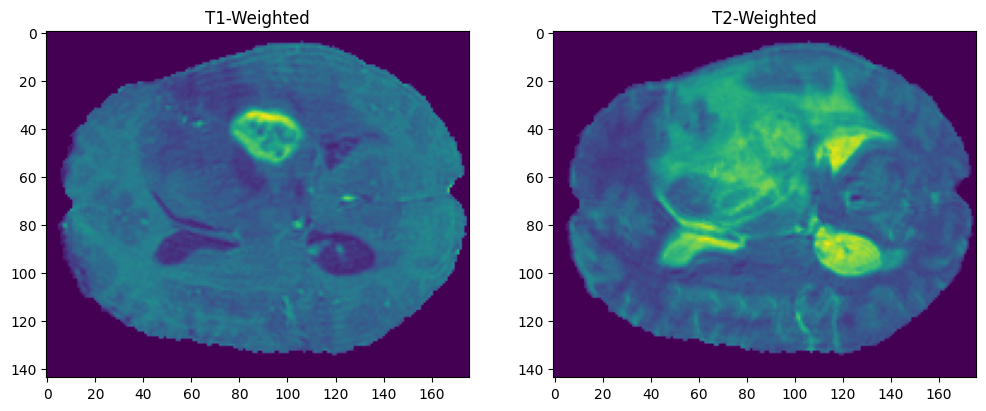

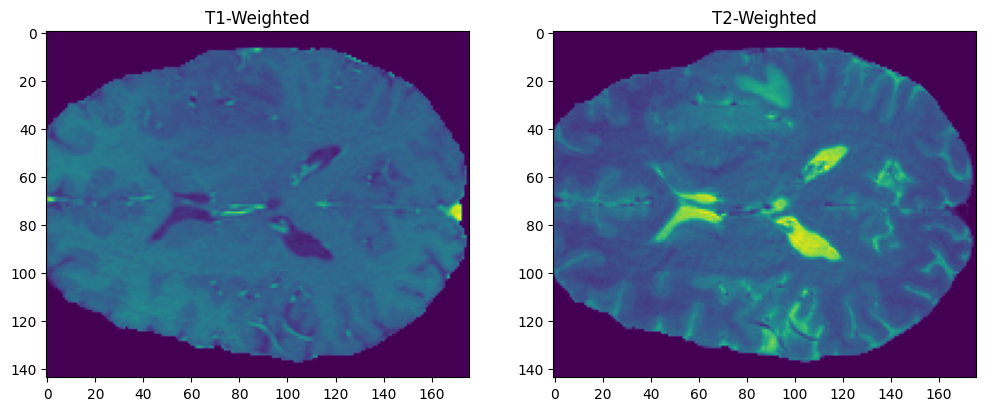

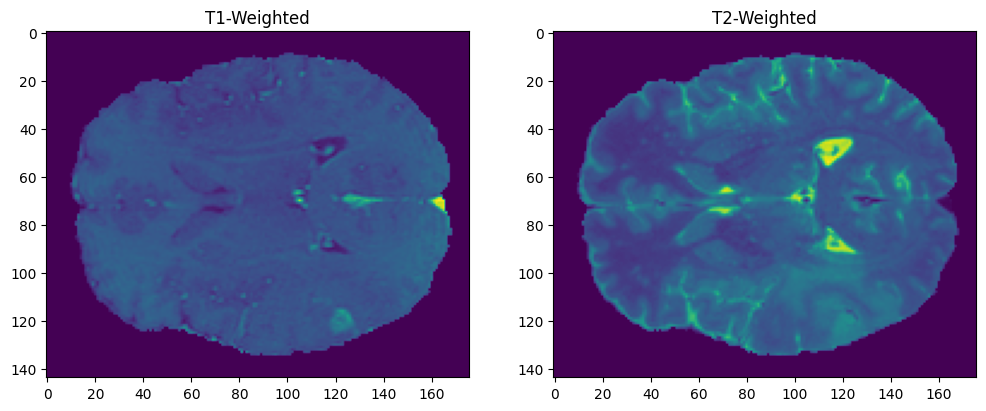

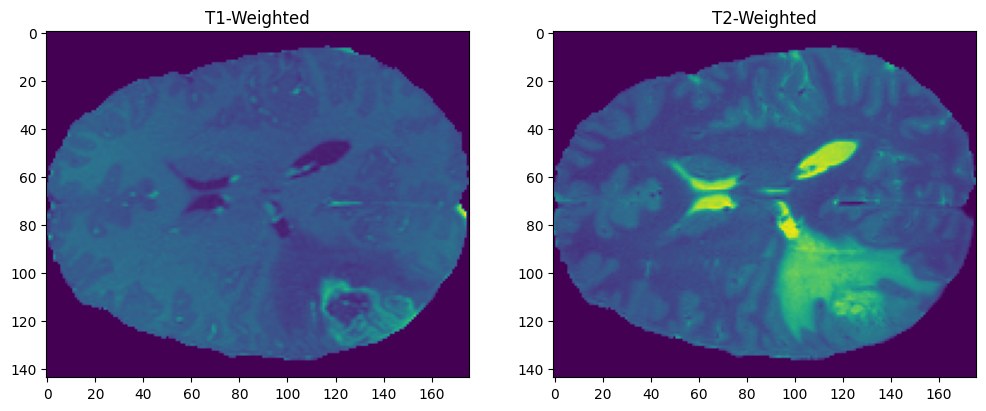

In [7]:
# directories to the t1 and t2 .npy files, repsectively
t1Dir = 'data/archive/MICCAI_BraTS2020_TrainingData/numpy/t1/'
t2Dir = 'data/archive/MICCAI_BraTS2020_TrainingData/numpy/t2/'

# use a small batch size for the sake of testing
batchSize = 4

# define an "instance" of the dataLoader function
testLoader = dataLoader(t1Dir, t2Dir, batchSize)

# fetch the first four t1 and t2 volumes 
(t1Images, t2Images) = testLoader.__next__()

# plot middle slices of the volumes
for i in range(t1Images.shape[0]):
    n = (0+t1Images.shape[3])//2
    plt.figure(figsize=(12,8))

    plt.subplot(121)
    plt.imshow(t1Images[i,:,:,n])
    plt.title('T1-Weighted')

    plt.subplot(122)
    plt.imshow(t2Images[i,:,:,n])
    plt.title('T2-Weighted')
    plt.show()
    

### Define Building Blocks for 2D and 3D U-Net
The U-Net architecture is composed of several encoder and decoder "blocks" (five of each in our implementation). Each of these blocks contains within it a sub-block of convolutions separated by ReLU activation functions. 

To avoid redundancy in our U-Net definition below, we define the DoubleConv classes, which implement this sub-block. Here, we define DoubleConv3D, which is used for our 3D U-Net, and DoubleConv2D, which is used for our 2D U-Net. These two classes are exactly the same, except that DoubleConv3D supports 3D volumes, whereas DoubleConv2D only supports 2D images.

In [8]:
class DoubleConv3D(nn.Module):
    def __init__(self, inChannels, outChannels):
        super(DoubleConv3D, self).__init__()
        
        self.conv1 = nn.Conv3d(in_channels=inChannels, out_channels=outChannels, kernel_size=3, stride=1, padding=1, bias=False)
        self.norm1 = nn.BatchNorm3d(outChannels)
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv3d(in_channels=outChannels, out_channels=outChannels, kernel_size=3, stride=1, padding=1, bias=False)
        self.norm2 = nn.BatchNorm3d(outChannels)
        self.relu2 = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        
        # BatchNorm2D expects a 4D input but x is only 3D, so we need to add an extra dimension
        x = torch.unsqueeze(x, dim=0)
        x = self.norm1(x)
        
        # remove the extra dimension before proceeding
        x = torch.squeeze(x, dim=0)
        x = self.relu1(x)
        
        x = self.conv2(x)
        
        # BatchNorm2D expects a 4D input but x is only 3D, so we need to add an extra dimension
        x = torch.unsqueeze(x, dim=0)
        x = self.norm2(x)
        
        # remove the extra dimension before proceeding
        x = torch.squeeze(x, dim=0)
        x = self.relu2(x)
        
        return x
        

In [9]:
class DoubleConv2D(nn.Module):
    def __init__(self, inChannels, outChannels):
        super(DoubleConv2D, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=inChannels, out_channels=outChannels, kernel_size=3, stride=1, padding=1, bias=False)
        self.norm1 = nn.BatchNorm2d(outChannels)
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(in_channels=outChannels, out_channels=outChannels, kernel_size=3, stride=1, padding=1, bias=False)
        self.norm2 = nn.BatchNorm2d(outChannels)
        self.relu2 = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        
        # BatchNorm3D expects a 5D input but x is only 4D, so we need to add an extra dimension
        x = torch.unsqueeze(x, dim=0)
        x = self.norm1(x)
        
        # remove the extra dimension before proceeding
        x = torch.squeeze(x, dim=0)
        x = self.relu1(x)
        
        x = self.conv2(x)
        
        # BatchNorm3D expects a 5D input but x is only 4D, so we need to add an extra dimension
        x = torch.unsqueeze(x, dim=0)
        x = self.norm2(x)
        
        # remove the extra dimension before proceeding
        x = torch.squeeze(x, dim=0)
        x = self.relu2(x)
        
        return x
        

### U-Net

Our architecture follows closely the original U-Net architecture, described in the following image.

<div>
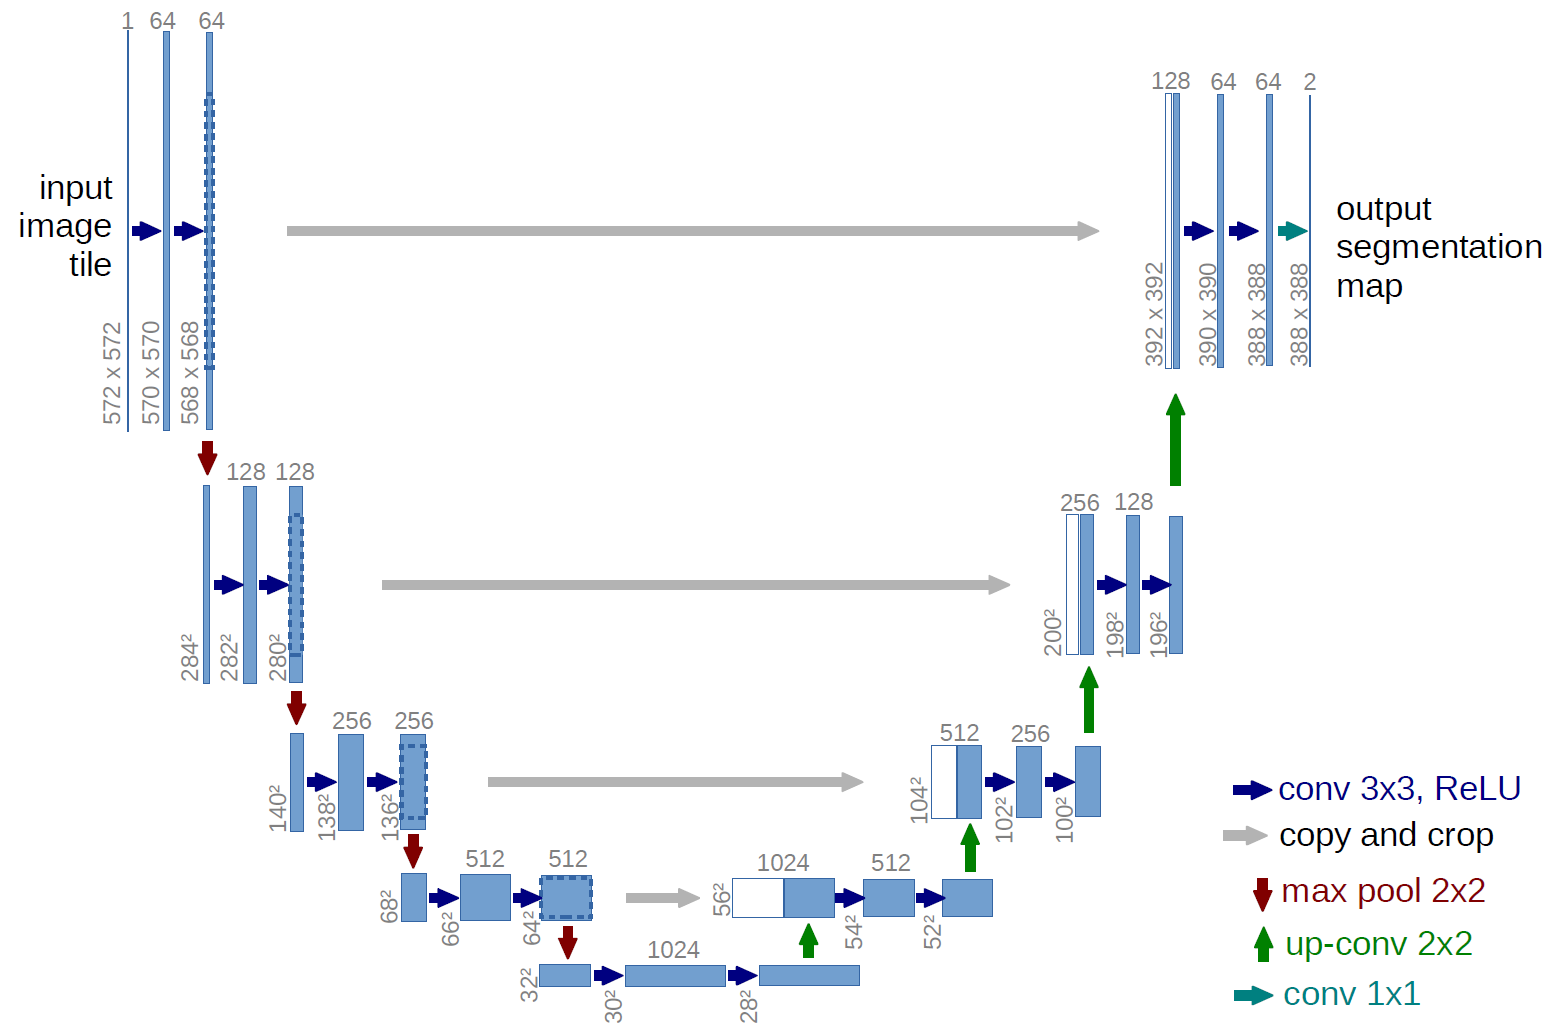
</div>

In this image, each rightward-pointing blue arrow defines a convolution, followed by a ReLU activation. Notice that these blue arrows always come in two's; a pair of two blue arrows taken together describes the DoubleConv operations defined above.

Our U-Net implementation differs from this implementation in two ways. 

First, we included a batch normalization inside of those blue arrows; so instead of describing a convlution followed by a ReLU activation, it describes a convolution followed by a batch normalization, followed by a ReLU activation.

Second, we added padding to all convolutions, to preserve image dimensions as they pass through. This made constructing the network much simpler, especially when it came to incorporating skip-connections.

Below, we define UNet3D and UNet2D classes. The main focus of this project is the UNet3D class; however, we were curious to see if we could get better performance out of a 2D network, hence UNet2D.

In [10]:
class UNet3D(nn.Module):
    def __init__(self):
        super(UNet3D, self).__init__()

        # encoder layers
        self.dc1 = DoubleConv3D(inChannels=1, outChannels=64)
        self.pool1 = nn.MaxPool3d(kernel_size=2, stride=2)
        
        self.dc2 = DoubleConv3D(inChannels=64, outChannels=128)
        self.pool2 = nn.MaxPool3d(kernel_size=2, stride=2)
        
        self.dc3 = DoubleConv3D(inChannels=128, outChannels=256)
        self.pool3 = nn.MaxPool3d(kernel_size=2, stride=2)
        
        self.dc4 = DoubleConv3D(inChannels=256, outChannels=512)
        self.pool4 = nn.MaxPool3d(kernel_size=2, stride=2)
        
        # decoder layers
        self.dc5 = DoubleConv3D(inChannels=512, outChannels=1024)
        self.conv5T = nn.ConvTranspose3d(in_channels=1024, out_channels=512, kernel_size=2, stride=2)
        
        self.dc6 = DoubleConv3D(inChannels=1024, outChannels=512)
        self.conv6T = nn.ConvTranspose3d(in_channels=512, out_channels=256, kernel_size=2, stride=2)
        
        self.dc7 = DoubleConv3D(inChannels=512, outChannels=256)
        self.conv7T = nn.ConvTranspose3d(in_channels=256, out_channels=128, kernel_size=2, stride=2)
        
        self.dc8 = DoubleConv3D(inChannels=256, outChannels=128)
        self.conv8T = nn.ConvTranspose3d(in_channels=128, out_channels=64, kernel_size=2, stride=2)
        
        self.dc9 = DoubleConv3D(inChannels=128, outChannels=64)
        self.conv9 = nn.Conv3d(in_channels=64, out_channels=1, kernel_size=1, stride=1, padding=0)
        
    def forward(self, x):
        # contraction path
        dc1out = self.dc1(x)
        pool1out = self.pool1(dc1out)
        
        dc2out = self.dc2(pool1out)
        pool2out = self.pool2(dc2out)

        dc3out = self.dc3(pool2out)
        pool3out = self.pool3(dc3out)
        
        dc4out = self.dc4(pool3out)
        pool4out = self.pool4(dc4out)
        
        # expansion path
        dc5out = self.dc5(pool4out)
        conv5Tout = self.conv5T(dc5out)
        
        # skip connection
        cat5out = torch.cat((dc4out, conv5Tout), dim=0)
        
        dc6out = self.dc6(cat5out)
        conv6Tout = self.conv6T(dc6out)
        
        # skip connection
        cat6out = torch.cat((dc3out, conv6Tout), dim=0)
        
        dc7out = self.dc7(cat6out)
        conv7Tout = self.conv7T(dc7out)
        
        # skip connection
        cat7out = torch.cat((dc2out, conv7Tout), dim=0)
        
        dc8out = self.dc8(cat7out)
        conv8Tout = self.conv8T(dc8out)
        
        # skip connection
        cat8out = torch.cat((dc1out, conv8Tout), dim=0)
        
        dc9out = self.dc9(cat8out)
        conv9out = self.conv9(dc9out)

        return conv9out

In [11]:
class UNet2D(nn.Module):
    def __init__(self):
        super(UNet2D, self).__init__()

        # encoder layers
        self.dc1 = DoubleConv2D(inChannels=1, outChannels=64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.dc2 = DoubleConv2D(inChannels=64, outChannels=128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.dc3 = DoubleConv2D(inChannels=128, outChannels=256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.dc4 = DoubleConv2D(inChannels=256, outChannels=512)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # decoder layers
        self.dc5 = DoubleConv2D(inChannels=512, outChannels=1024)
        self.conv5T = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=2, stride=2)        
        self.dc6 = DoubleConv2D(inChannels=1024, outChannels=512)
        self.conv6T = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2)        
        self.dc7 = DoubleConv2D(inChannels=512, outChannels=256)
        self.conv7T = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2)        
        self.dc8 = DoubleConv2D(inChannels=256, outChannels=128)
        self.conv8T = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2)        
        self.dc9 = DoubleConv2D(inChannels=128, outChannels=64)
        self.conv9 = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, stride=1, padding=0)
        
    def forward(self, x):
        # contraction path
        dc1out = self.dc1(x)
        pool1out = self.pool1(dc1out)
        
        dc2out = self.dc2(pool1out)
        pool2out = self.pool2(dc2out)

        dc3out = self.dc3(pool2out)
        pool3out = self.pool3(dc3out)
        
        dc4out = self.dc4(pool3out)
        pool4out = self.pool4(dc4out)
        
        # expansion path
        dc5out = self.dc5(pool4out)
        conv5Tout = self.conv5T(dc5out)
        
        # skip connection
        cat5out = torch.cat((dc4out, conv5Tout), dim=0)
        
        dc6out = self.dc6(cat5out)
        conv6Tout = self.conv6T(dc6out)
        
        # skip connection
        cat6out = torch.cat((dc3out, conv6Tout), dim=0)
        
        dc7out = self.dc7(cat6out)
        conv7Tout = self.conv7T(dc7out)
        
        # skip connection
        cat7out = torch.cat((dc2out, conv7Tout), dim=0)
        
        dc8out = self.dc8(cat7out)
        conv8Tout = self.conv8T(dc8out)
        
        # skip connection
        cat8out = torch.cat((dc1out, conv8Tout), dim=0)
        
        dc9out = self.dc9(cat8out)
        conv9out = self.conv9(dc9out)

        return conv9out

### Define Function to Train the Model

The following function can be used to train both 2D and 3D models. To train a 2D model, simply set the dim parameter as 2; similarly, set dim as 3 to train a 3D model. 

The number of epochs to train the model for is specified on line 5, and the batch size is inherent to the dataLoader object being passed in. 

In [12]:
def train(dataLoader, model, optimizer, lossFunction, dim):
    print(f'Beginning Training on {model.__class__.__name__}...')
    
    # loop over the dataset multiple times
    nepochs = 100
    for epoch in range(nepochs):
        
        # keep running loss for every image in an epoch
        epochLoss = 0.0
        
        # fetch a new batch from the data loader
        data = dataLoader.__next__()
        batchSize = data[0].shape[0]
        
        # n will be used to index the volume to get the middle slice
        n = (0+data[0].shape[3])//2

        # process each image in a batch
        for b in range(batchSize): 
            # when 3D, send volumes to device
            if dim == 3:
                inputs = data[0][b:b+1].to(device)
                labels = data[1][b:b+1].to(device)
            # when 2D, send only the middle slice
            elif dim == 2:
                inputs = data[0][b:b+1][:,:,:,n].to(device)
                labels = data[1][b:b+1][:,:,:,n].to(device)
                
            # forward
            outputs = model(inputs)
            loss = lossFunction(outputs, labels)
            
            # backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # add loss to running loss
            epochLoss += loss.item()

        # print statistics
        if epoch % 20 == 0:
            print(f'epoch: {epoch}\ttrain loss: {epochLoss/batchSize}')
    

### Define Function to Test the Model

The following function can be used to test both 2D and 3D models. To test a 2D model, simply set the dim parameter as 2; similarly, set dim as 3 to test a 3D model. 

The batch size of the validation set is inherent to the dataLoader object being passed in. Typically, batch size will be set to 125, as this is the number of images in our validation dataset. 

This function will compute and print the average loss across each volume in the batch, and plot paired T1, T2, and predicted T2 images of every 20th volume. 

In [13]:
def test(dataLoader, model, optimizer, lossFunction, dim):    
    print(f'\n\n\n\nBeginning Testing on {model.__class__.__name__}...')
    
    # get the images and labels from the dataLoader
    images, labels = dataLoader.__next__()
    batchSize = images.shape[0]
    
    # n will be used to index the volume to get the middle slice
    n = (0+images.shape[3])//2
    averageLoss = 0.0
    
    with torch.no_grad():
        for b in range(batchSize):
            # when 3D, send a volume to the device
            if dim == 3:
                img = torch.unsqueeze(images[b], dim=0).to(device)
                lab = torch.unsqueeze(labels[b], dim=0).to(device)
            # when 2D, send only the middle slice
            elif dim == 2:
                img = torch.unsqueeze(images[b], dim=0)[:,:,:,n].to(device)
                lab = torch.unsqueeze(labels[b], dim=0)[:,:,:,n].to(device)

            # get model output, compute loss, add to running loss
            output = model(img)
            loss = lossFunction(output, lab)
            averageLoss += loss.item()
            
            # display every 20th image pair
            if b % 20 == 0:
                print(f'loss for b={b}:', loss.item())

                # plot a random slice of the output and label
                plt.figure(figsize=(12,8))

                plt.subplot(131)
                plt.imshow((img[0,:,:,n] if dim == 3 else img[0,:,:]).cpu())
                plt.title('T1 Image')

                plt.subplot(132)
                plt.imshow((lab[0,:,:,n] if dim == 3 else lab[0,:,:]).cpu())
                plt.title('T2 Image')

                plt.subplot(133)
                plt.imshow((output[0,:,:,n] if dim == 3 else output[0,:,:]).cpu())
                plt.title('Predicted T2 Image')
                plt.show()
        
        print(f'Average loss across all validation images: {averageLoss/batchSize}')
            

### Define Functions to Save & Load the Model

The following two functions can be used to save a model to, or load a model from, a .pth file.

In [14]:
def save(model, dim):
    modelDir = 'model/'
    if not os.path.exists(modelDir):
        os.makedirs(modelDir)
    
    torch.save(model.state_dict(), modelDir+f'model{dim}d.pth')

def load(dim):
    path = f'model/model{dim}d.pth'
    model = torch.load(path)

### Train & Test 2D Model

This cell trains and evaluates UNet2D, using the train and test functions defined above. This is where you would modify the optimizer, loss function, and batch sizes being used.

device: cuda:0
Beginning Training on UNet2D...
epoch: 0	train loss: 0.15988115966320038
epoch: 20	train loss: 0.006473734392784536
epoch: 40	train loss: 0.020099262706935406
epoch: 60	train loss: 0.02115704375319183
epoch: 80	train loss: 0.011687650461681187




Beginning Testing on UNet2D...
loss for b=0: 0.006496848538517952


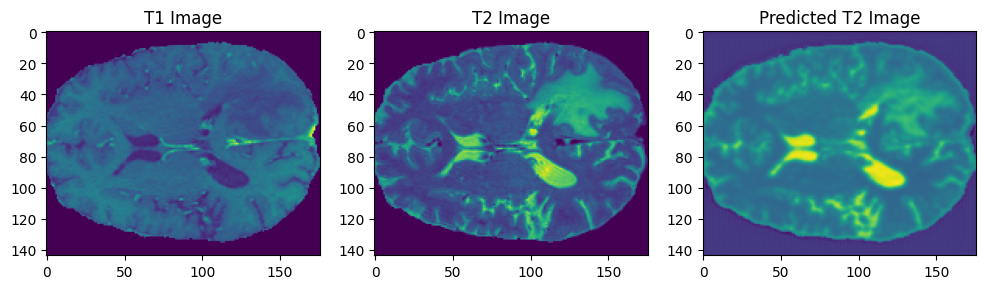

loss for b=20: 0.007770830299705267


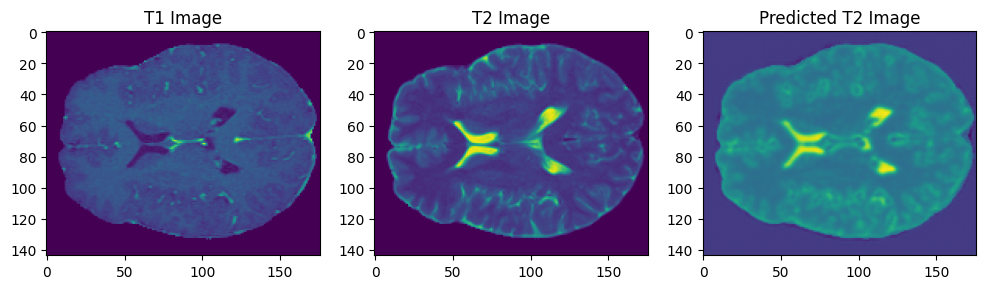

loss for b=40: 0.00664285896345973


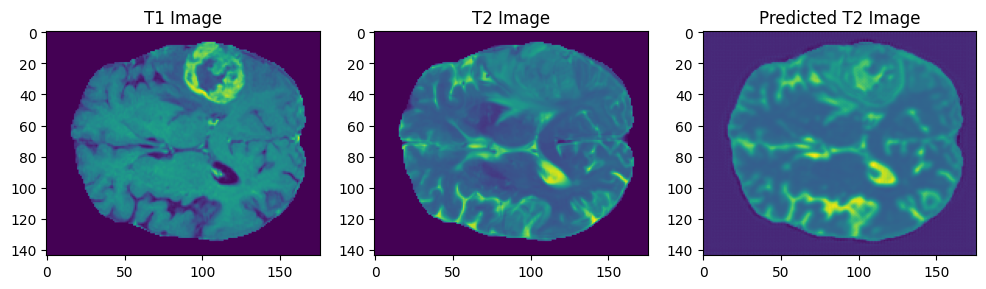

loss for b=60: 0.010724091902375221


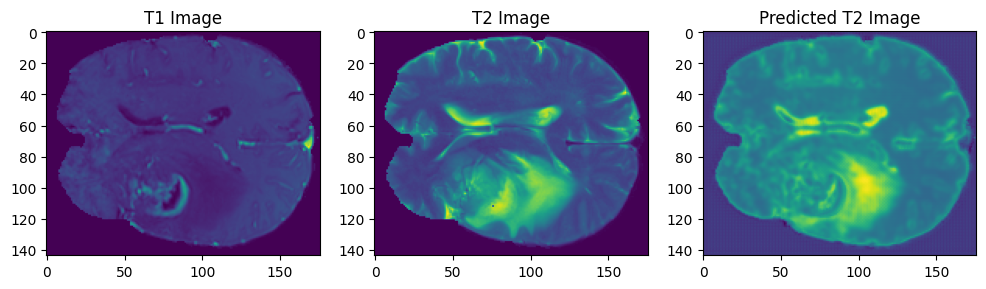

loss for b=80: 0.00774609437212348


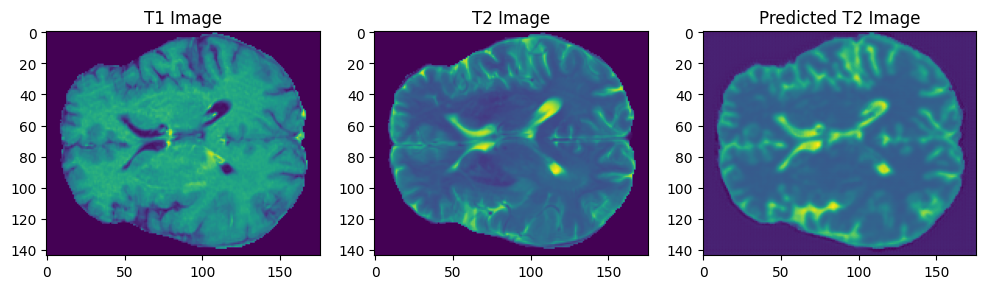

loss for b=100: 0.053606532514095306


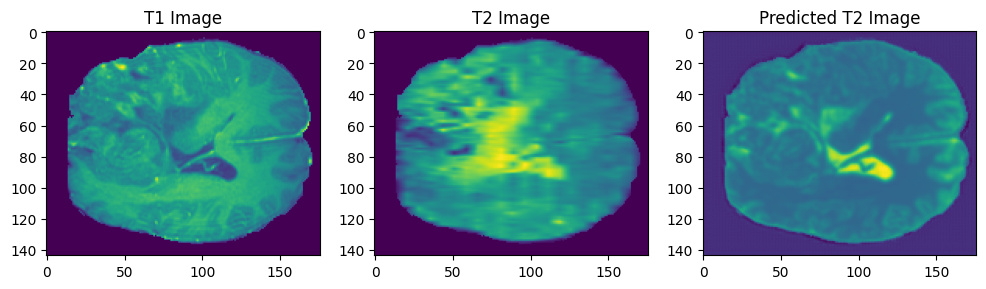

loss for b=120: 0.004904811270534992


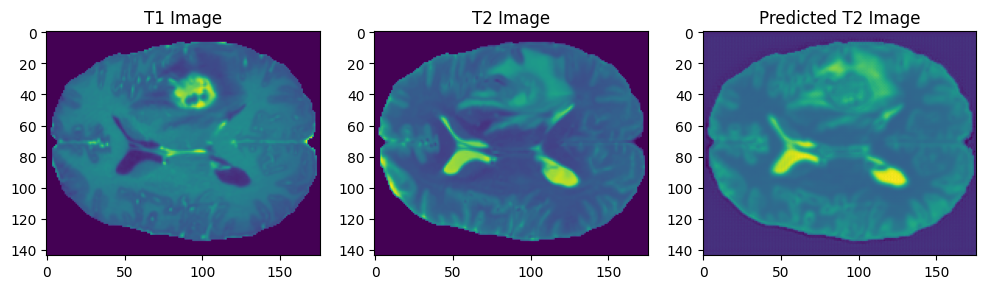

Average loss across all validation images: 0.021763440545648337


In [15]:
# use cuda if available, otherwise cpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'device: {device}')

# create dataLoader (batch size of 4)
t1Dir = 'data/archive/MICCAI_BraTS2020_TrainingData/numpy/t1/'
t2Dir = 'data/archive/MICCAI_BraTS2020_TrainingData/numpy/t2/'
batchSize = 4
trainLoader = dataLoader(t1Dir, t2Dir, batchSize)

# test the model
t1Dir = 'data/archive/MICCAI_BraTS2020_ValidationData/numpy/t1/'
t2Dir = 'data/archive/MICCAI_BraTS2020_ValidationData/numpy/t2/'
batchSize = 125
validationLoader = dataLoader(t1Dir, t2Dir, batchSize)

# instantiate model and send to device
unet2d = UNet2D().to(device)

# specify loss criterion and optimizer
criterion = nn.MSELoss()
optimizer2d = optim.Adam(unet2d.parameters(),lr=1e-3)

# train the model
train(trainLoader, unet2d, optimizer2d, criterion, 2)

# test the model
test(validationLoader, unet2d, optimizer2d, criterion, 2)


### Train & Test 3D Model

This cell trains and evaluates UNet3D, using the train and test functions defined above. This is where you would modify the optimizer, loss function, and batch sizes being used.

device: cuda:0
Beginning Training on UNet3D...
epoch: 0	train loss: 1.1464087963104248
epoch: 20	train loss: 0.008097651763819158
epoch: 40	train loss: 0.02335585094988346
epoch: 60	train loss: 0.014947367133572698
epoch: 80	train loss: 0.008201999007724226




Beginning Testing on UNet3D...
loss for b=0: 0.007912452332675457


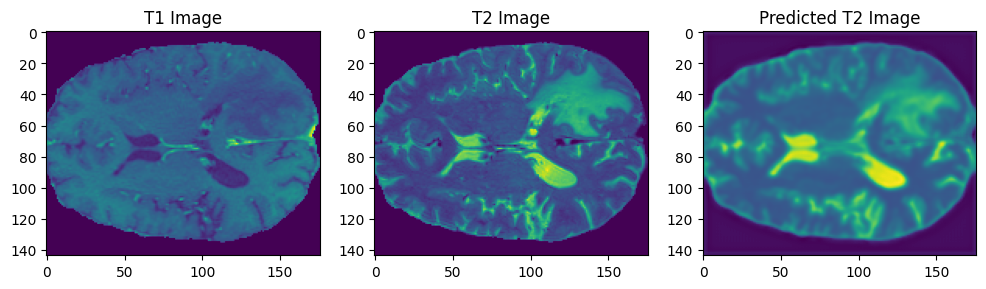

loss for b=20: 0.007806791923940182


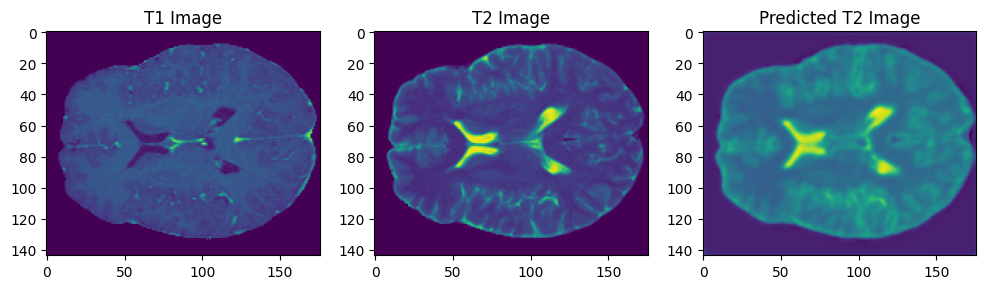

loss for b=40: 0.007591691333800554


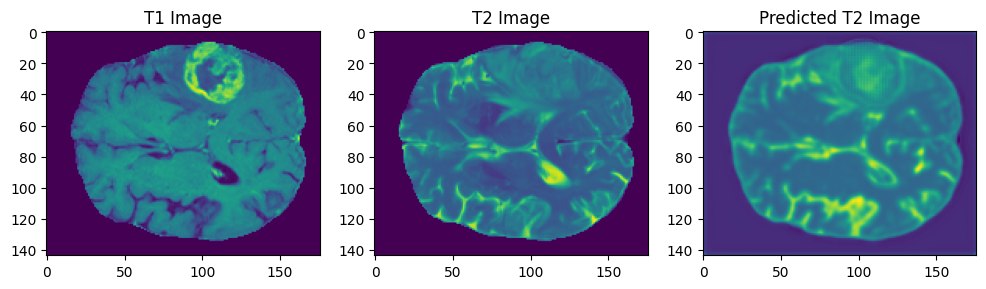

loss for b=60: 0.008972765877842903


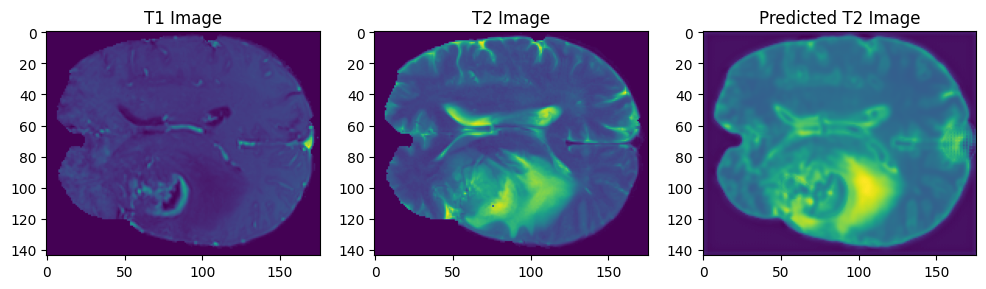

loss for b=80: 0.009363996796309948


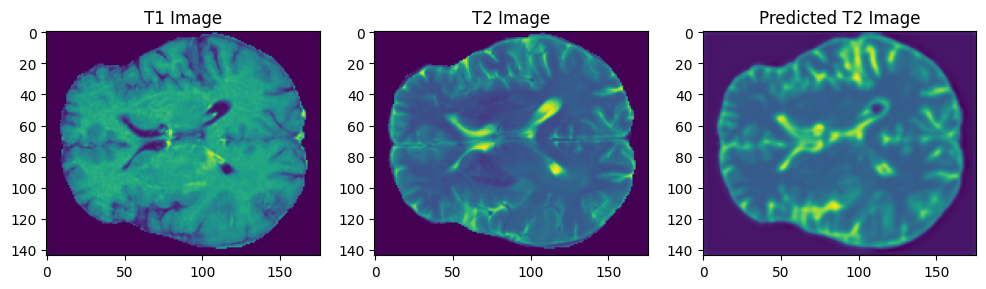

loss for b=100: 0.04441643878817558


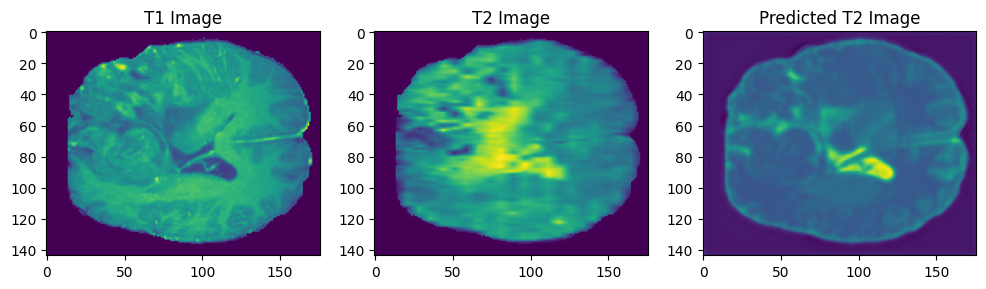

loss for b=120: 0.005488315597176552


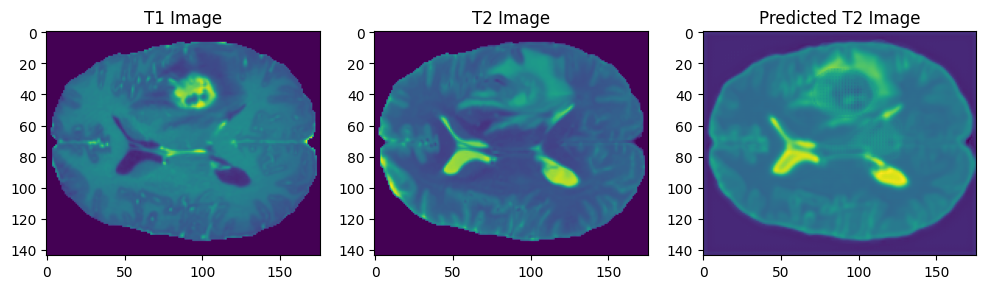

Average loss across all validation images: 0.019833981338888407


In [16]:
# use cuda if available, otherwise cpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'device: {device}')

# create dataLoader (batch size of 4)
t1Dir = 'data/archive/MICCAI_BraTS2020_TrainingData/numpy/t1/'
t2Dir = 'data/archive/MICCAI_BraTS2020_TrainingData/numpy/t2/'
batchSize = 4
trainLoader = dataLoader(t1Dir, t2Dir, batchSize)

# test the model
t1Dir = 'data/archive/MICCAI_BraTS2020_ValidationData/numpy/t1/'
t2Dir = 'data/archive/MICCAI_BraTS2020_ValidationData/numpy/t2/'
batchSize = 125
validationLoader = dataLoader(t1Dir, t2Dir, batchSize)

# instantiate model and send to device
unet3d = UNet3D().to(device)

# specify loss criterion and optimizer
criterion = nn.MSELoss()
optimizer3d = optim.Adam(unet3d.parameters(),lr=1e-3)

# train the model
train(trainLoader, unet3d, optimizer3d, criterion, 3)

# test the model
test(validationLoader, unet3d, optimizer3d, criterion, 3)


### Save the Models

Run this cell (optionally) to save the two models.

In [18]:
# save(unet2d,2)
# save(unet3d,3)